<a href="https://colab.research.google.com/github/vichidamba/maksimus_emotion-recognition/blob/main/Face-emotion/Ravdess_video_classification(worst_results).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images
from sklearn.model_selection import train_test_split
from glob import glob
from tqdm import tqdm
import pandas as pd
import os
import sys

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
ravdess_zip="/content/drive/MyDrive/videos.zip"

In [ ]:
!unzip "/content/drive/MyDrive/videos.zip" -d "/content/tempo"

Archive:  /content/drive/MyDrive/videos.zip
   creating: /content/tempo/videos/
  inflating: /content/tempo/videos/01-01-07-02-02-02-03.mp4  
  inflating: /content/tempo/__MACOSX/videos/._01-01-07-02-02-02-03.mp4  
  inflating: /content/tempo/videos/01-01-04-02-02-01-17.mp4  
  inflating: /content/tempo/__MACOSX/videos/._01-01-04-02-02-01-17.mp4  
  inflating: /content/tempo/videos/01-01-07-02-02-02-17.mp4  
  inflating: /content/tempo/__MACOSX/videos/._01-01-07-02-02-02-17.mp4  
  inflating: /content/tempo/videos/01-01-04-02-02-01-03.mp4  
  inflating: /content/tempo/__MACOSX/videos/._01-01-04-02-02-01-03.mp4  
  inflating: /content/tempo/videos/01-01-03-02-02-01-13.mp4  
  inflating: /content/tempo/__MACOSX/videos/._01-01-03-02-02-01-13.mp4  
  inflating: /content/tempo/videos/01-01-03-02-02-01-07.mp4  
  inflating: /content/tempo/__MACOSX/videos/._01-01-03-02-02-01-07.mp4  
  inflating: /content/tempo/videos/01-01-03-01-01-01-07.mp4  
  inflating: /content/tempo/__MACOSX/videos/._01

In [ ]:
Ravdess_Speech_Videos = "/content/Ravdess_Videos/videos"
ravdess_directory_list = os.listdir(Ravdess_Speech_Videos)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    part = dir.split('.')[0]
    part = part.split('-')
        # third part in each file represents the emotion associated to that file.
    file_emotion.append(int(part[2]))
    file_path.append(dir)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Filename'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()
	

,Emotions,Filename
0,happy,01-01-03-02-02-01-02.mp4
1,sad,01-01-04-02-02-01-04.mp4
2,fear,01-01-06-01-02-01-23.mp4
3,sad,01-01-04-02-02-02-03.mp4
4,surprise,01-01-08-01-02-01-22.mp4


In [ ]:
Ravdess_df.Filename.head()

0    01-01-03-02-02-01-02.mp4
1    01-01-04-02-02-01-04.mp4
2    01-01-06-01-02-01-23.mp4
3    01-01-04-02-02-02-03.mp4
4    01-01-08-01-02-01-22.mp4
Name: Filename, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


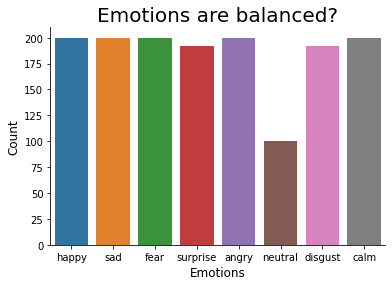

In [ ]:
import seaborn as sns
plt.title('Emotions are balanced?', size=20)
sns.countplot(Ravdess_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 100

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [ ]:
def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [ ]:
! pip3 install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-2gtfi2_l
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-2gtfi2_l
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=180247 sha256=d9055c0f2fe236a4b5b5f239ee5f3d2910fc55847c809ceaaaa4c796b8ea93e7
  Stored in directory: /tmp/pip-ephem-wheel-cache-qti7cy1b/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [ ]:
! pip3 install --upgrade imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [ ]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

In [ ]:
Ravdess_df_train, Ravdess_df_test = train_test_split(Ravdess_df, test_size=0.2)

print(f"Total videos for training: {len(Ravdess_df_train)}")
print(f"Total videos for testing: {len(Ravdess_df_test)}")

Ravdess_df_test.head(10)

Total videos for training: 1187
Total videos for testing: 297


,Emotions,Filename
1150,angry,01-01-05-01-01-01-21.mp4
272,fear,01-02-06-02-02-01-01.mp4
967,fear,01-01-06-02-02-01-11.mp4
1460,disgust,01-01-07-02-02-02-13.mp4
1237,neutral,01-01-01-01-02-02-03.mp4
19,surprise,01-01-08-01-02-01-02.mp4
1063,calm,01-01-02-01-01-01-13.mp4
261,sad,01-01-04-01-01-01-10.mp4
896,fear,01-01-06-01-02-02-16.mp4
452,happy,01-01-03-02-01-01-06.mp4


In [ ]:
label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(Ravdess_df_train["Emotions"]))
print(label_processor.get_vocabulary())

['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["Filename"].values.tolist()
    labels = df["Emotions"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(Ravdess_df_train, "train")
test_data, test_labels = prepare_all_videos(Ravdess_df_test, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")
# print(f"Frame labels in train set: {train_labels[1].shape}")

Frame features in train set: (1187, 20, 2048)
Frame masks in train set: (1187, 20)


In [ ]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_experiment()

Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 2.0788 - accuracy: 0.1373
Epoch 1: val_loss improved from inf to 2.07890, saving model to /tmp/video_classifier
26/26 [==============================] - 13s 174ms/step - loss: 2.0788 - accuracy: 0.1373 - val_loss: 2.0789 - val_accuracy: 0.1204
Epoch 2/100
26/26 [==============================] - ETA: 0s - loss: 2.0771 - accuracy: 0.1470
Epoch 2: val_loss improved from 2.07890 to 2.07826, saving model to /tmp/video_classifier
26/26 [==============================] - 2s 86ms/step - loss: 2.0771 - accuracy: 0.1470 - val_loss: 2.0783 - val_accuracy: 0.1204
Epoch 3/100
26/26 [==============================] - ETA: 0s - loss: 2.0756 - accuracy: 0.1349
Epoch 3: val_loss improved from 2.07826 to 2.07771, saving model to /tmp/video_classifier
26/26 [==============================] - 2s 85ms/step - loss: 2.0756 - accuracy: 0.1349 - val_loss: 2.0777 - val_accuracy: 0.1204
Epoch 4/100
26/26 [==============================] - ETA:

In [ ]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


In [ ]:
# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
# def to_gif(images):
#     converted_images = images.astype(np.uint8)
#     imageio.mimsave("animation.gif", converted_images, fps=10)
#     return embed.embed_file("animation.gif")


test_video = np.random.choice(Ravdess_df_test["Filename"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
# to_gif(test_frames[:MAX_SEQ_LENGTH])

Test video path: 01-01-08-02-01-01-09.mp4
  happy: 13.95%
  sad: 13.83%
  fear: 13.60%
  angry: 13.29%
  calm: 12.37%
  disgust: 12.14%
  surprise: 12.00%
  neutral:  8.82%
